# Movie Recommendations with SVD

Recommender systems are employed across many domains to provide personalized suggestions to users. Many sources will often claim that SVD is a possible choice for providing these recommendations, but this is only true under certain assumptions.

In this notebook, we will build a move recommendation model using SVD under these assumptions. Afterwards, we will explore what to do when these assumptions break down.

To understand what SVD is doing, our first example will contain 8 users and 5 movies. The ratings are as follows:

| User    | The Matrix | Titanic | Gladiator | Amadeus | Pride & Prejudice |
| ------- | ---------- | ------- | --------- | ------- | ----------------- |
| Darrow  | 5          | 4       | 5         | 5       | 5                 |
| Sevro   | 3          | 5       | 4         | 1       | 5                 |
| Mustang | 3          | 5       | 3         | 4       | 4                 |
| Victra  | 5          | 1       | 5         | 1       | 1                 |
| Kavax   | 4          | 4       | 4         | 4       | 4                 |
| Cassius | 5          | 5       | 5         | 5       | 5                 |
| Pax     | 4          | 2       | 3         | 4       | 3                 |
| Eo      | 2          | 4       | 3         | 4       | 4                 |

In [1]:
import numpy as np
import matplotlib.pyplot as plt

users = ['Darrow', 'Sevro', 'Mustang', 'Victra', 'Kavax', 'Cassius', 'Pax', 'Eo']
movies = ['The Matrix', 'Titanic', 'Gladiator', 'Amadeus', 'Pride & Prejudice']
ratings = np.array([[5, 4, 5, 5, 5],
                    [3, 5, 4, 1, 5],
                    [3, 5, 3, 4, 4],
                    [5, 1, 5, 1, 1],
                    [4, 4, 4, 4, 4],
                    [5, 5, 5, 5, 5],
                    [4, 2, 3, 4, 3],
                    [2, 4, 3, 4, 4]])

# Compute SVD
U, s, Vt = np.linalg.svd(ratings, full_matrices=False)

# What is SVD?

Before we use the results of SVD to provide recommendations, let's have a quick refresher on what SVD is. SVD is a matrix factorization technique that decomposes a matrix into three matrices: $U$, $\Sigma$, and $V^T$. They clearly contain information related to the original data matrix, but **what do these matrices mean?**

The first step of SVD is to create a square matrix $S = A^TA$. One can also do the same with $S = AA^T$ -- both options will yield the same singular values. $S$ is a matrix that is the dot product of every row with itself. This yields, in essence, a measure of similarity between the rows. Where the [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix) is a measure of the variance of the data, $S$ measures the total variance (including the mean).

The left singular vectors of $S$ can be thought of as features of the data. If $S$ encompasses the similarities between movie ratings from our dataset, its eigenvectors ($A$'s singular vectors) encompass some transformed representation of that data. It is hard to say exactly what they encode, but you could think of the first singular vector as a popularity score, for example. Another singular vector may represent genre, such as action or drama.

# Visualizing the top 2 singular vectors

Visualizing the users and movies in the space of the first two singular vectors can help us understand how SVD is working. Let's start with the users.

[[-0.43769917  0.08538042]
 [-0.33221806 -0.18652503]
 [-0.34593107 -0.32055966]
 [-0.2392079   0.8421295 ]
 [-0.36472744 -0.01065811]
 [-0.45590931 -0.01332263]
 [-0.29066491  0.17081773]
 [-0.3095099  -0.341333  ]]


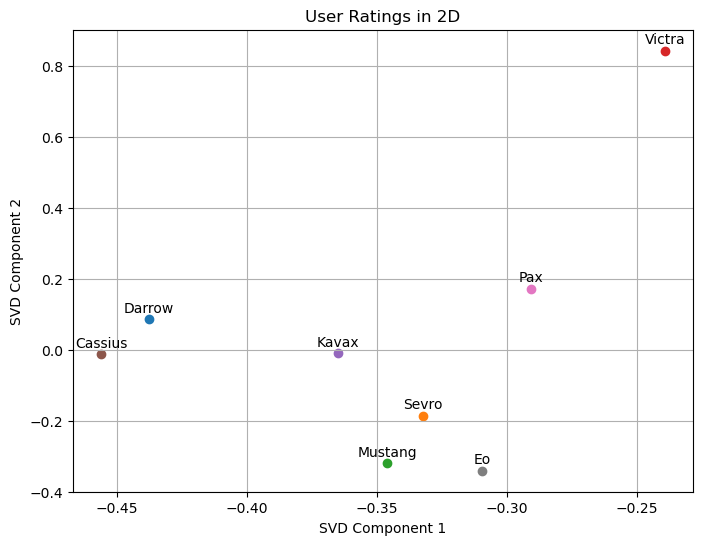

In [2]:
print(U[:, :2])

# Plot each user
plt.figure(figsize=(8, 6))
for i in range(len(users)):
    plt.scatter(U[i, 0], U[i, 1], label=users[i])
# Add name labels above each point
for i, user in enumerate(users):
    plt.text(U[i, 0], U[i, 1] + 0.02, user, ha='center')
plt.title('User Ratings in 2D')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.grid()
plt.show()

The results agree with the ratings of the original users. Darrow and Cassius have given similar ratings to all of the films, so they are close together in this space. Victra isn't a fan of these movies and has scored them all poorly. She is farther away from the rest as a result.

Let's now plot the movies. If $U$ encodes the user features, $V$ encodes the movie features.

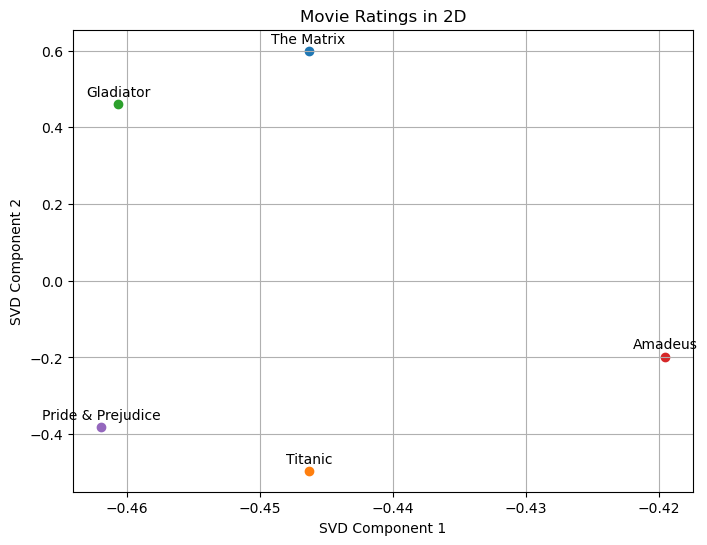

In [3]:
V = Vt.T # Transpose Vt to get V

# Plot each movie
plt.figure(figsize=(8, 6))
for i in range(len(movies)):
    plt.scatter(V[i, 0], V[i, 1], label=movies[i])
# Add name labels above each point
for i, movie in enumerate(movies):
    plt.text(V[i, 0], V[i, 1] + 0.02, movie, ha='center')
plt.title('Movie Ratings in 2D')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.grid()
plt.show()

Based on the ratings the users have given, we can see that fans of Gladiator are more likely to enjoy The Matrix than they are Titanic, for example. Note that this does not reflect the actual ratings of the movies, but the similarity between the ratings from the users.

# Making Recommendations

Given this information, how do we actually make recommendations? Let's say Lyria is a fan of Gladiator. We could simply recommend The Matrix since they are close in this space. What if her preferences are a little more complex? For example, she likes the Matrix and would give it a 4, but she was not a fan of Pride & Prejudice and scored it a 2. How can we recommend a movie to her?

In that case, we project the user's preferences for their select movies onto the corresponding singular vectors.

$$
\mathbf{u}_{\text{new}} = \sum_i r_i \mathbf{v}_i^T \sigma_i^{-1},
$$

where $r_i$ is the user's rating for movie $i$. The sum above only includes the movies that the user has rated. The result is a new user vector that can be used to find the closest movie to Lyria's preferences.

In [4]:
def recommend(ratings, V, Sigma, top_n=1):
    # ratings: dict {movie_id: rating}
    movie_indices = list(ratings.keys())
    rated_V = V[movie_indices, :]  # Subset of V for rated movies
    
    # Project new user into latent space
    u_new = np.sum([ratings[id] * rated_V[i] / Sigma[i] 
                    for i, id in enumerate(movie_indices)], axis=0)
    
    # Predict scores for all movies
    predicted_scores = u_new @ np.diag(Sigma) @ V.T
    
    # Exclude already rated movies by setting their scores to -infinity
    predicted_scores[movie_indices] = -np.inf
    
    # Get top-N recommendations (excluding seen movies)
    top_items = np.argsort(predicted_scores)[-top_n:][::-1]
    return top_items


# Example usage
new_user_ratings = {0: 4, 4: 2}  # Ratings for 'The Matrix' and 'Price & Prejudice'
recommended_movies = recommend(new_user_ratings, V, s)
print("Recommended movie:", [movies[i] for i in recommended_movies])


Recommended movie: ['Titanic']


Given Lyria's ratings, the recommendation makes sense. We can test our understanding by varying her preferences a bit. What if she really disliked Pride & Prejudice and gave it a 1?

In [5]:
new_user_ratings = {0: 4, 4: 1}  # Ratings for 'The Matrix' and 'Price & Prejudice'
recommended_movies = recommend(new_user_ratings, V, s)
print("Recommended movie:", [movies[i] for i in recommended_movies])

Recommended movie: ['Gladiator']


In that case, she was recommend Gladiator.

# Scaling up the data

Now that we have a pipeline for making recommendations, let's scale up the data. We are going to use [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data) from Kaggle. This dataset has 26 million ratings from over 270,000 users on over 45,000 movies. So that we can fit everything into memory, we will use the smaller version which includes 100,000 ratings from 700 users on 9,000 movies.

In [6]:
import pandas as pd

path = "/home/alex/Downloads/movies_dataset/ratings_small.csv"
df = pd.read_csv(path)
df = df.drop(columns=["timestamp"]) # Drop the timestamp column

df.head()

# Convert to a matrix
ratings = df.pivot(index="userId", columns="movieId", values="rating")

print(ratings.head())

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5           NaN     NaN     4.0     NaN     NaN     NaN     NaN     NaN   

movieId  9       10      ...  161084  161155  161594  161830  161918  161944  \
userId                   ...                                                   
1           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2           NaN     4.0  ...     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     4.0  ...     NaN     NaN     NaN     NaN     NaN     N

# Dealing with Missing Data

We have a huge problem with this dataset. Not every user has make a recommendation for every movie. That means we have a lot of missing data. SVD can not be computed on a matrix with missing data. The solution to this problem is called **data imputation**. The goal is to come up with a reasonable strategy to fill in the missing values so that we can compute SVD.

We could spend a lot of time debating about the best way to impute the data, but we will explore 2 simple approaches: 
1. **Mean imputation**: This is the simplest approach. We simply fill in the missing values with the mean rating for that movie. This is a reasonable approach, but it has some drawbacks. For example, if a user has rated 5 movies and they all have a mean rating of 4, we will fill in the missing values with 4. This means that we are assuming that the user would have rated the missing movies the same as the average rating for that movie.
2. **Zero imputation**: This is a more aggressive approach. We simply fill in the missing values with 0. This means that we are assuming that the user has not rated the movie at all. This is a reasonable approach, but it has some drawbacks. For example, if a user has rated 5 movies and they all have a mean rating of 4, we will fill in the missing values with 0. This means that we are assuming that the user would have rated the missing movies the same as 0.

In [7]:
# Approach 1: Mean imputation
ratings_mean = ratings.mean(axis=1)
ratings_mean = ratings_mean.fillna(0)
ratings_mean = ratings_mean.values.reshape(-1, 1)
ratings_mean = np.tile(ratings_mean, (1, ratings.shape[1]))
ratings_mean = pd.DataFrame(ratings_mean, columns=ratings.columns)
ratings_mean.index = ratings.index
ratings_mean.head()

# Compute SVD
U, s, Vt = np.linalg.svd(ratings_mean, full_matrices=False)